# Aggregated Feature Extraction and Statistical Analysis

This notebook demonstrates feature extraction and aggregation analysis using the AFX library with the ESC-50 dataset.

## Objectives

1. **Multi-Feature Extraction**: Extract various types of features (mel spectrogram, cepstral, harmonic, time-domain)
2. **Aggregation Comparison**: Compare different aggregation strategies (mean, std, summary, stack)
3. **Statistical Analysis**: Analyze feature distributions by class and identify discriminative features
4. **Correlation Analysis**: Explore inter-feature relationships and redundancy
5. **Dimensionality Analysis**: Apply PCA to understand feature variability

## Prerequisites

- ESC-50 dataset downloaded and extracted
- AFX library installed
- Environment variable `ESC_50_dataset` pointing to dataset root


## Setup and Imports

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import defaultdict
import json

# AFX imports
from AFX.io.io import load_audio
from AFX.utils.config_loader import load_config
from AFX.extract_all import extract_all_features
from AFX.utils.aggregator import aggregate_features
from AFX.utils.visualization import plot_feature_distribution

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print('✓ All imports successful')

✓ All imports successful


## Dataset Setup and Verification

In [2]:
# Load dataset paths from environment or use fallback
DATASET_PATH = os.getenv('ESC_50_dataset')
if DATASET_PATH is None:
    DATASET_PATH = '../data/ESC-50-master'  # Fallback path

audio_path = os.path.join(DATASET_PATH, 'audio')
metadata_path = os.path.join(DATASET_PATH, 'meta', 'esc50.csv')
config_path = os.path.join('config.json')

# Verify dataset structure
print("📁 Dataset Structure Verification:")
print(f"Audio directory: {audio_path} - {'✓ exists' if os.path.exists(audio_path) else '❌ missing'}")
print(f"Metadata file: {metadata_path} - {'✓ exists' if os.path.exists(metadata_path) else '❌ missing'}")
print(f"Config file: {config_path} - {'✓ exists' if os.path.exists(config_path) else '❌ missing'}")

if not all([os.path.exists(audio_path), os.path.exists(metadata_path), os.path.exists(config_path)]):
    print("\n❌ Dataset structure verification failed!")
    print("Please ensure the ESC-50 dataset is properly extracted and the path is correct.")
    sys.exit(1)
else:
    print("\n✓ Dataset structure verification passed!")

📁 Dataset Structure Verification:
Audio directory: D:\datasets\ESC-50-master\audio - ✓ exists
Metadata file: D:\datasets\ESC-50-master\meta\esc50.csv - ✓ exists
Config file: config.json - ✓ exists

✓ Dataset structure verification passed!


## Load and Sample Dataset

In [3]:
# Load ESC-50 metadata
try:
    metadata = pd.read_csv(metadata_path)
    print(f"✓ Successfully loaded metadata with {len(metadata)} samples")
    
    # Display dataset overview
    print(f"\n📊 Dataset Overview:")
    print(f"Total samples: {len(metadata)}")
    print(f"Number of classes: {metadata['category'].nunique()}")
    print(f"Number of folds: {metadata['fold'].nunique()}")
    
    # Show class distribution
    print(f"\n📈 Class Distribution (top 10):")
    class_counts = metadata['category'].value_counts()
    print(class_counts.head(10))
    
except Exception as e:
    print(f"❌ Error loading metadata: {e}")
    sys.exit(1)

✓ Successfully loaded metadata with 2000 samples

📊 Dataset Overview:
Total samples: 2000
Number of classes: 50
Number of folds: 5

📈 Class Distribution (top 10):
category
dog                40
chirping_birds     40
vacuum_cleaner     40
thunderstorm       40
door_wood_knock    40
can_opening        40
crow               40
clapping           40
fireworks          40
chainsaw           40
Name: count, dtype: int64


In [4]:
# Select a balanced subset for analysis (to keep processing time reasonable)
SAMPLES_PER_CLASS = 5  # Adjust based on computational resources
TOP_CLASSES = 10       # Focus on top N classes

# Get most frequent classes
top_classes = metadata['category'].value_counts().head(TOP_CLASSES).index.tolist()
print(f"Selected classes for analysis: {top_classes}")

# Sample data from each class
sampled_data = []
for category in top_classes:
    class_data = metadata[metadata['category'] == category].sample(
        min(SAMPLES_PER_CLASS, len(metadata[metadata['category'] == category])), 
        random_state=42
    )
    sampled_data.append(class_data)

# Combine sampled data
sample_metadata = pd.concat(sampled_data, ignore_index=True)
print(f"\n✓ Selected {len(sample_metadata)} samples from {len(top_classes)} classes")
print(f"Distribution: {sample_metadata['category'].value_counts().to_dict()}")

Selected classes for analysis: ['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw']

✓ Selected 50 samples from 10 classes
Distribution: {'dog': 5, 'chirping_birds': 5, 'vacuum_cleaner': 5, 'thunderstorm': 5, 'door_wood_knock': 5, 'can_opening': 5, 'crow': 5, 'clapping': 5, 'fireworks': 5, 'chainsaw': 5}


## Configuration and Feature Setup

In [5]:
# Load and customize AFX configuration
config = load_config(config_path)

# Ensure we don't aggregate initially to see raw feature shapes
config['preserve_shape'] = True
config['return_metadata'] = False

print("🔧 AFX Configuration:")
print(f"Sample rate: {config['sample_rate']} Hz")
print(f"Available features: {list(config['features'].keys())}")
print(f"Feature preservation: {config.get('preserve_shape', False)}")

# Define feature categories for analysis
FEATURE_CATEGORIES = {
    'time_domain': ['zcr', 'variance'],
    'spectral': ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'],
    'cepstral': ['mfcc', 'mfcc_delta', 'melspectrogram', 'gfcc'],
    'harmonic': ['pitch', 'thd', 'hnr'],
    'chroma': ['chroma_cqt']
}

print(f"\n📋 Feature categories for analysis:")
for category, features in FEATURE_CATEGORIES.items():
    print(f"  {category}: {features}")

🔧 AFX Configuration:
Sample rate: 22050 Hz
Available features: ['zcr', 'variance', 'kurtosis', 'autocorr_variance', 'mobility', 'complexity', 'sample_entropy', 'energy_ratio', 'short_time_energy', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_contrast', 'spectral_entropy', 'spectral_flatness', 'spectral_flux', 'spectral_skewness', 'spectral_slope', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta_delta', 'chroma_stft', 'chroma_cqt', 'cqt', 'pitch', 'thd', 'hnr', 'gfcc']
Feature preservation: True

📋 Feature categories for analysis:
  time_domain: ['zcr', 'variance']
  spectral: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff']
  cepstral: ['mfcc', 'mfcc_delta', 'melspectrogram', 'gfcc']
  harmonic: ['pitch', 'thd', 'hnr']
  chroma: ['chroma_cqt']


## Multi-Feature Extraction

In [6]:
# Extract features from all selected samples
print("🔍 Extracting features from selected samples...")

extracted_features = []
labels = []
file_info = []

for idx, row in sample_metadata.iterrows():
    filename = row['filename']
    category = row['category']
    file_path = os.path.join(audio_path, filename)
    
    try:
        # Load audio
        signal, sr = load_audio(file_path, sr=config['sample_rate'])
        
        # Extract all features
        features = extract_all_features(signal, sr, config)
        
        extracted_features.append(features)
        labels.append(category)
        file_info.append({'filename': filename, 'category': category, 'duration': len(signal)/sr})
        
        if len(extracted_features) % 10 == 0:
            print(f"  Processed {len(extracted_features)} samples...")
            
    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")
        continue

print(f"\n✓ Successfully extracted features from {len(extracted_features)} samples")
print(f"✓ Feature types extracted: {list(extracted_features[0].keys()) if extracted_features else 'None'}")

🔍 Extracting features from selected samples...


  Processed 10 samples...
  Processed 20 samples...
  Processed 30 samples...
  Processed 40 samples...
  Processed 50 samples...

✓ Successfully extracted features from 50 samples
✓ Feature types extracted: ['zcr', 'variance', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_skewness', 'spectral_slope', 'melspectrogram', 'mfcc', 'mfcc_delta', 'chroma_cqt', 'pitch', 'thd', 'hnr', 'gfcc']


In [7]:
# Analyze feature shapes and properties
if extracted_features:
    print("📐 Feature Shape Analysis:")
    sample_features = extracted_features[0]
    
    for feat_name, feat_data in sample_features.items():
        print(f"  {feat_name:20s}: {feat_data.shape} (dtype: {feat_data.dtype})")
        
    print(f"\n📊 Feature Statistics (first sample):")
    for feat_name, feat_data in sample_features.items():
        flat_data = feat_data.flatten()
        print(f"  {feat_name:20s}: mean={flat_data.mean():.4f}, std={flat_data.std():.4f}, min={flat_data.min():.4f}, max={flat_data.max():.4f}")

📐 Feature Shape Analysis:
  zcr                 : (212,) (dtype: float64)
  variance            : (1,) (dtype: float32)
  rms_energy          : (1,) (dtype: float32)
  spectral_centroid   : (212,) (dtype: float64)
  spectral_bandwidth  : (212,) (dtype: float64)
  spectral_rolloff    : (212,) (dtype: float64)
  spectral_skewness   : (212,) (dtype: float64)
  spectral_slope      : (212,) (dtype: float64)
  melspectrogram      : (128, 216) (dtype: float64)
  mfcc                : (13, 212) (dtype: float64)
  mfcc_delta          : (13, 212) (dtype: float64)
  chroma_cqt          : (12, 212) (dtype: float64)
  pitch               : (212,) (dtype: float64)
  thd                 : (1,) (dtype: float32)
  hnr                 : (212,) (dtype: float32)
  gfcc                : (13, 212) (dtype: float64)

📊 Feature Statistics (first sample):
  zcr                 : mean=0.3562, std=0.3318, min=0.0464, max=0.9932
  variance            : mean=0.0100, std=0.0000, min=0.0100, max=0.0100
  rms_energy  

## Aggregation Strategy Comparison

Compare different methods for aggregating time-series features into fixed-size representations.

In [8]:
# Define aggregation methods to compare
AGGREGATION_METHODS = ['mean', 'std', 'summary', 'stack']

# Apply different aggregation methods to all extracted features
aggregated_datasets = {}

for method in AGGREGATION_METHODS:
    print(f"\n🔄 Applying '{method}' aggregation...")
    method_results = []
    
    for features in extracted_features:
        try:
            if method == 'stack':
                # Stack method returns numpy array directly
                agg_result = aggregate_features(features, method=method, flatten=True)
                method_results.append(agg_result)
            else:
                # Other methods return feature dictionaries
                agg_result = aggregate_features(features, method=method, flatten=True)
                method_results.append(agg_result)
        except Exception as e:
            print(f"❌ Error in {method} aggregation: {e}")
            continue
    
    aggregated_datasets[method] = method_results
    
    if method == 'stack':
        print(f"✓ {method} aggregation completed: {len(method_results)} samples, shape {method_results[0].shape if method_results else 'N/A'}")
    else:
        if method_results:
            total_features = sum(len(result) for result in method_results) // len(method_results)
            print(f"✓ {method} aggregation completed: {len(method_results)} samples, {total_features} features per sample")

print(f"\n✅ Aggregation comparison completed for methods: {list(aggregated_datasets.keys())}")


🔄 Applying 'mean' aggregation...
✓ mean aggregation completed: 50 samples, 16 features per sample

🔄 Applying 'std' aggregation...
✓ std aggregation completed: 50 samples, 16 features per sample

🔄 Applying 'summary' aggregation...
✓ summary aggregation completed: 50 samples, 32 features per sample

🔄 Applying 'stack' aggregation...
✓ stack aggregation completed: 50 samples, shape (40159,)

✅ Aggregation comparison completed for methods: ['mean', 'std', 'summary', 'stack']


In [9]:
# Analyze aggregation method characteristics
print("📊 Aggregation Method Analysis:")

for method, results in aggregated_datasets.items():
    if not results:
        continue
        
    print(f"\n🔍 {method.upper()} Method:")
    
    if method == 'stack':
        # Stack method produces numpy arrays
        sample_shape = results[0].shape
        total_features = sample_shape[0] if len(sample_shape) > 0 else 0
        print(f"  Features per sample: {total_features}")
        print(f"  Data type: numpy array")
        
        # Statistical summary
        sample_data = results[0]
        print(f"  Sample statistics: mean={sample_data.mean():.4f}, std={sample_data.std():.4f}")
        
    else:
        # Dictionary-based methods
        sample_result = results[0]
        feature_names = list(sample_result.keys())
        print(f"  Feature count: {len(feature_names)}")
        print(f"  Feature names: {feature_names[:5]}{'...' if len(feature_names) > 5 else ''}")
        
        # Compute total dimensionality
        total_dim = sum(np.prod(v.shape) for v in sample_result.values())
        print(f"  Total dimensions: {total_dim}")
        
        # Show example feature statistics
        for feat_name, feat_data in list(sample_result.items())[:3]:
            flat_data = feat_data.flatten()
            print(f"    {feat_name}: {flat_data.shape[0]} dims, mean={flat_data.mean():.4f}")

📊 Aggregation Method Analysis:

🔍 MEAN Method:
  Feature count: 16
  Feature names: ['zcr', 'variance', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth']...
  Total dimensions: 190
    zcr: 1 dims, mean=0.3562
    variance: 1 dims, mean=0.0100
    rms_energy: 1 dims, mean=0.0998

🔍 STD Method:
  Feature count: 16
  Feature names: ['zcr', 'variance', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth']...
  Total dimensions: 190
    zcr: 1 dims, mean=0.3318
    variance: 1 dims, mean=0.0000
    rms_energy: 1 dims, mean=0.0000

🔍 SUMMARY Method:
  Feature count: 32
  Feature names: ['zcr_mean', 'zcr_std', 'variance_mean', 'variance_std', 'rms_energy_mean']...
  Total dimensions: 380
    zcr_mean: 1 dims, mean=0.3562
    zcr_std: 1 dims, mean=0.3318
    variance_mean: 1 dims, mean=0.0100

🔍 STACK Method:
  Features per sample: 40159
  Data type: numpy array
  Sample statistics: mean=48.3715, std=545.6770


## Statistical Analysis by Class and Feature Type

In [10]:
# Prepare data for statistical analysis using 'mean' aggregation
mean_aggregated = aggregated_datasets.get('mean', [])

if mean_aggregated:
    print("📈 Statistical Analysis by Class and Feature Type")
    
    # Convert to structured format for analysis
    feature_data_by_class = defaultdict(lambda: defaultdict(list))
    
    for i, (features, label) in enumerate(zip(mean_aggregated, labels)):
        for feat_name, feat_values in features.items():
            flat_values = feat_values.flatten()
            feature_data_by_class[label][feat_name].extend(flat_values)
    
    # Compute class-wise statistics
    class_statistics = {}
    
    for class_name in feature_data_by_class:
        class_statistics[class_name] = {}
        for feat_name in feature_data_by_class[class_name]:
            values = np.array(feature_data_by_class[class_name][feat_name])
            class_statistics[class_name][feat_name] = {
                'mean': values.mean(),
                'std': values.std(),
                'median': np.median(values),
                'skewness': stats.skew(values),
                'kurtosis': stats.kurtosis(values),
                'count': len(values)
            }
    
    print(f"✓ Computed statistics for {len(class_statistics)} classes")
    print(f"✓ Features analyzed: {list(next(iter(class_statistics.values())).keys())[:5]}...")
else:
    print("❌ No mean aggregated data available for statistical analysis")

📈 Statistical Analysis by Class and Feature Type
✓ Computed statistics for 10 classes
✓ Features analyzed: ['zcr', 'variance', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth']...


In [11]:
# Identify most discriminative features using class separation metrics
if mean_aggregated:
    print("🎯 Discriminative Feature Analysis")
    
    discriminative_scores = {}
    
    # For each feature, compute between-class vs within-class variance ratio
    for feat_name in next(iter(class_statistics.values())).keys():
        class_means = [class_statistics[cls][feat_name]['mean'] for cls in class_statistics]
        class_stds = [class_statistics[cls][feat_name]['std'] for cls in class_statistics]
        
        # Between-class variance
        overall_mean = np.mean(class_means)
        between_class_var = np.var(class_means)
        
        # Within-class variance (average)
        within_class_var = np.mean([std**2 for std in class_stds])
        
        # Discriminative score (higher = more discriminative)
        if within_class_var > 0:
            discriminative_scores[feat_name] = between_class_var / within_class_var
        else:
            discriminative_scores[feat_name] = float('inf')
    
    # Sort by discriminative power
    sorted_features = sorted(discriminative_scores.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\n🏆 Top 10 Most Discriminative Features:")
    for i, (feat_name, score) in enumerate(sorted_features[:10]):
        print(f"  {i+1:2d}. {feat_name:20s}: {score:.4f}")
    
    print(f"\n🔻 Bottom 5 Least Discriminative Features:")
    for i, (feat_name, score) in enumerate(sorted_features[-5:]):
        print(f"  {len(sorted_features)-4+i:2d}. {feat_name:20s}: {score:.4f}")
    
    # Store for later visualization
    most_discriminative = [name for name, _ in sorted_features[:10]]
    least_discriminative = [name for name, _ in sorted_features[-5:]]


🎯 Discriminative Feature Analysis

🏆 Top 10 Most Discriminative Features:
   1. spectral_centroid   : 2.7794
   2. spectral_skewness   : 2.6438
   3. spectral_slope      : 2.4245
   4. zcr                 : 2.3676
   5. spectral_bandwidth  : 2.1169
   6. spectral_rolloff    : 2.1051
   7. pitch               : 1.9851
   8. hnr                 : 0.9263
   9. rms_energy          : 0.9135
  10. variance            : 0.6766

🔻 Bottom 5 Least Discriminative Features:
  12. mfcc_delta          : 0.0391
  13. gfcc                : 0.0298
  14. melspectrogram      : 0.0255
  15. mfcc                : 0.0237
  16. chroma_cqt          : 0.0000


🏆 Top 10 Most Discriminative Features:
   1. spectral_centroid   : 2.7794
   2. spectral_skewness   : 2.6438
   3. spectral_slope      : 2.4245
   4. zcr                 : 2.3676
   5. spectral_bandwidth  : 2.1169
   6. spectral_rolloff    : 2.1051
   7. pitch               : 1.9851
   8. hnr                 : 0.9263
   9. rms_energy          : 0.9135
  

## Feature Distribution Visualization

📊 Creating feature distribution visualizations...


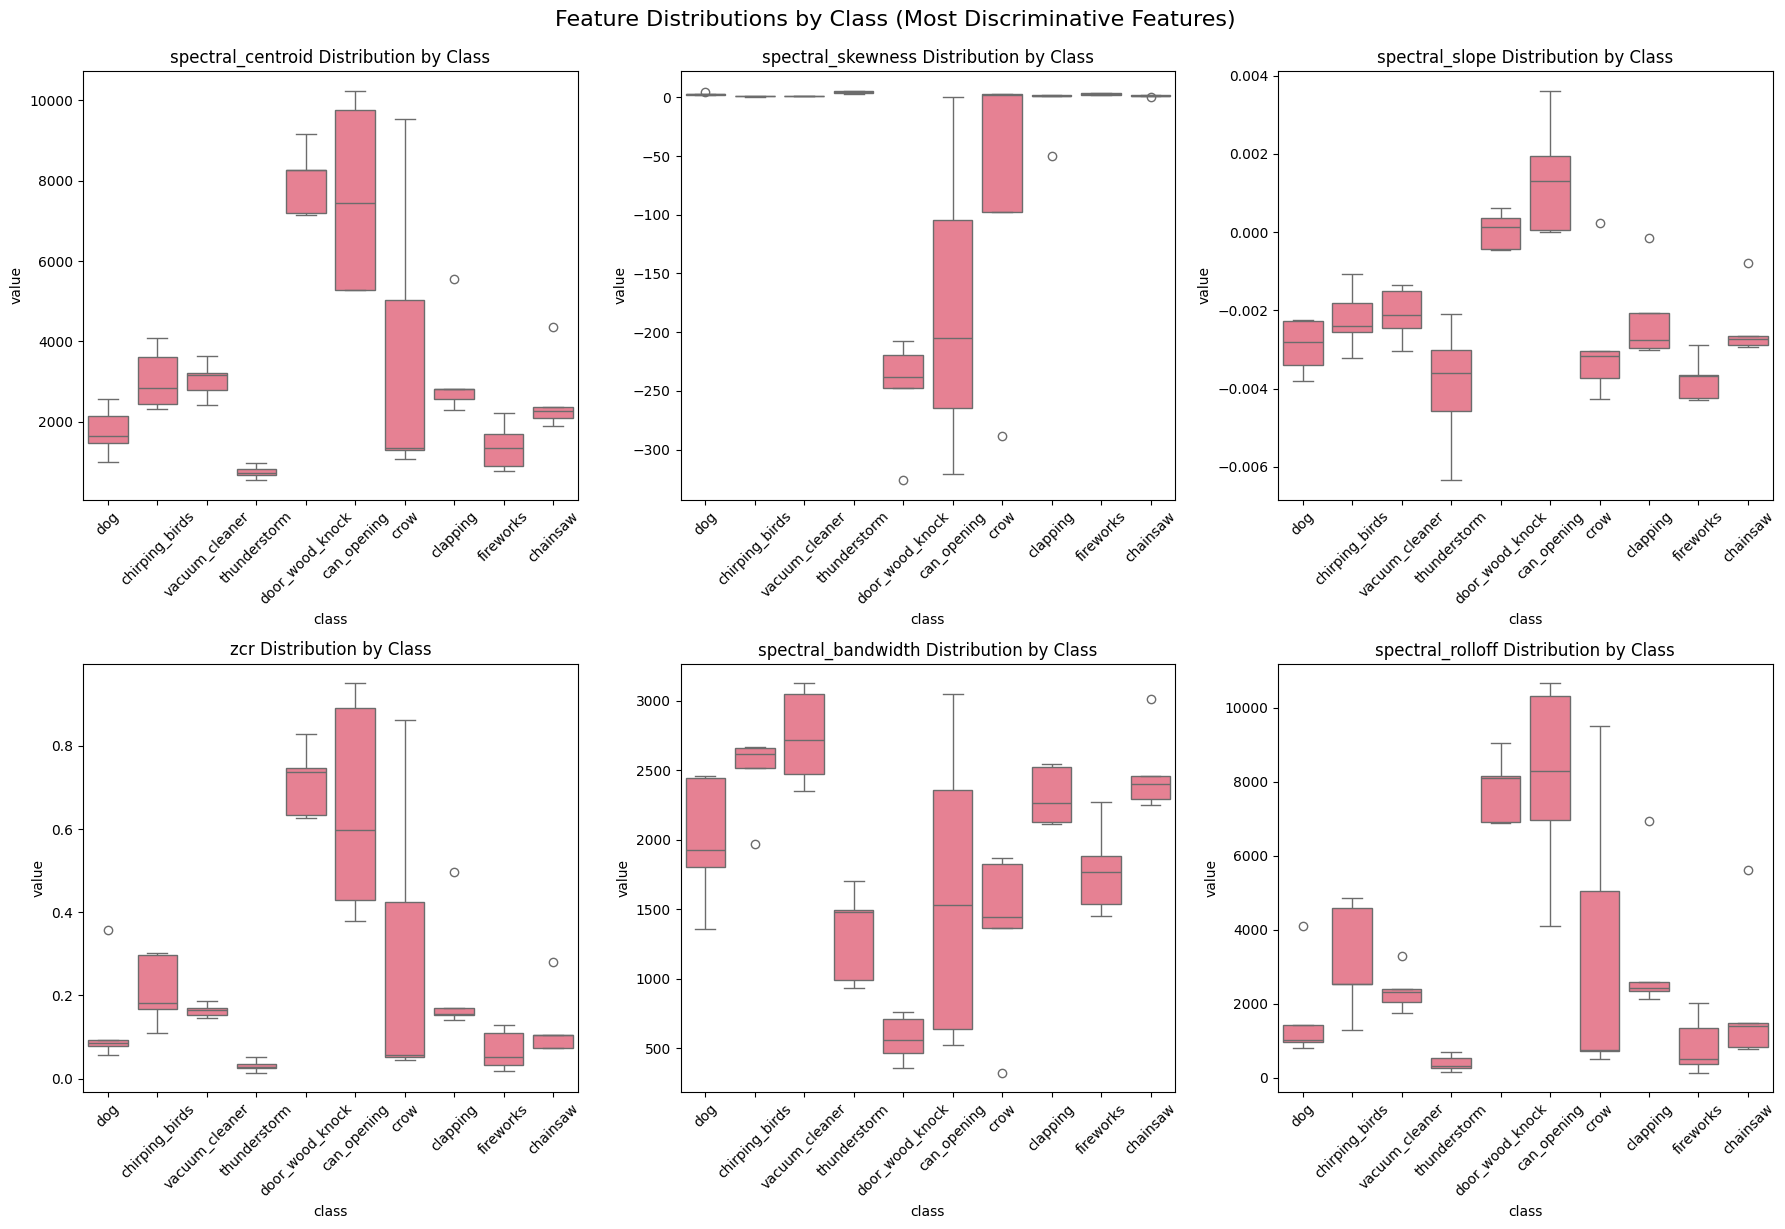

✓ Feature distribution plots created


In [12]:
# Create boxplots for most discriminative features by class
if mean_aggregated and 'most_discriminative' in locals():
    print("📊 Creating feature distribution visualizations...")
    
    # Prepare data for plotting
    plot_data = []
    
    for i, (features, label) in enumerate(zip(mean_aggregated, labels)):
        for feat_name in most_discriminative[:6]:  # Plot top 6 discriminative features
            if feat_name in features:
                values = features[feat_name].flatten()
                for value in values:
                    plot_data.append({
                        'feature': feat_name,
                        'value': value,
                        'class': label
                    })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create subplots for boxplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feat_name in enumerate(most_discriminative[:6]):
        feat_data = plot_df[plot_df['feature'] == feat_name]
        if not feat_data.empty:
            sns.boxplot(data=feat_data, x='class', y='value', ax=axes[i])
            axes[i].set_title(f'{feat_name} Distribution by Class')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.suptitle('Feature Distributions by Class (Most Discriminative Features)', y=1.02, fontsize=16)
    plt.show()
    
    print("✓ Feature distribution plots created")

📋 Feature Category Analysis

🏷️ Feature Category Discriminative Power:
  spectral    : avg_score=2.3338, max_score=2.7794, features=3
  time_domain : avg_score=1.5221, max_score=2.3676, features=2
  harmonic    : avg_score=1.1036, max_score=1.9851, features=3
  cepstral    : avg_score=0.0314, max_score=0.0391, features=5
  chroma      : avg_score=0.0000, max_score=0.0000, features=1


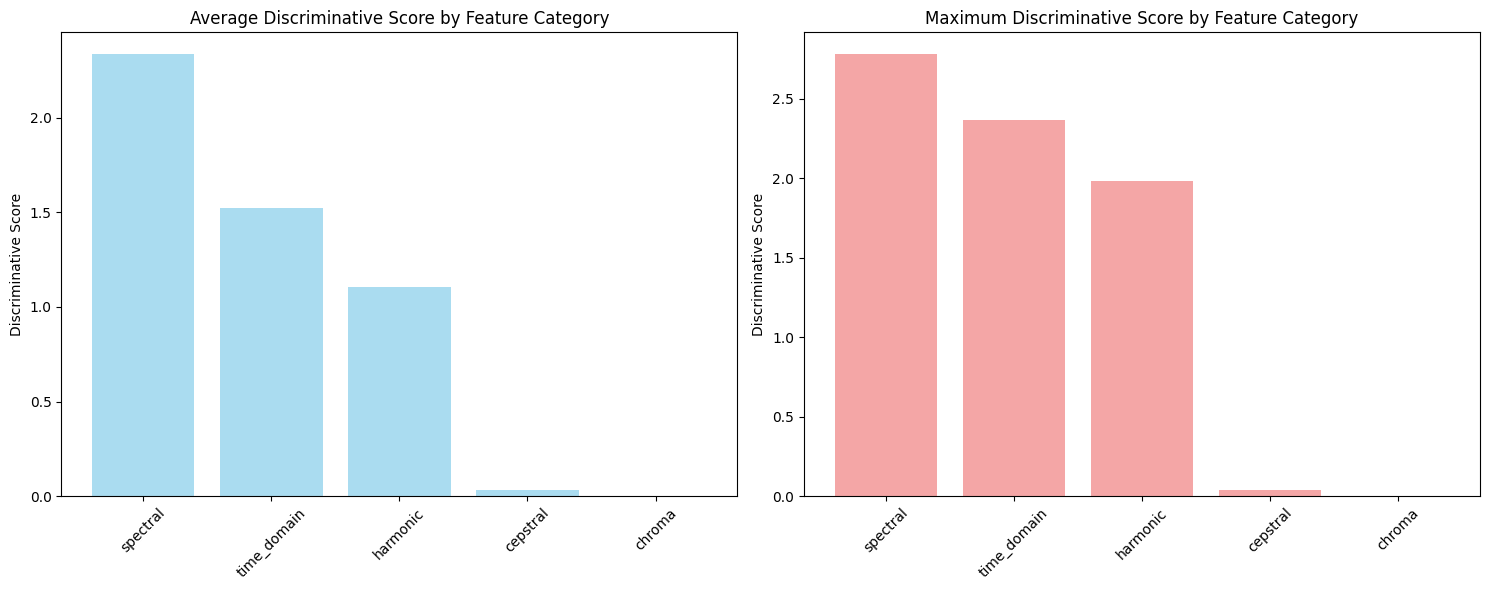

✓ Feature category analysis plots created


In [13]:
# Create summary statistics by feature category
if mean_aggregated:
    print("📋 Feature Category Analysis")
    
    category_stats = {}
    
    for category, feature_list in FEATURE_CATEGORIES.items():
        category_discriminative_scores = []
        category_features_found = []
        
        for feat_name in feature_list:
            # Check for exact match or features that start with the name
            matching_features = [f for f in discriminative_scores.keys() 
                               if f == feat_name or f.startswith(feat_name + '_')]
            
            for matching_feat in matching_features:
                category_discriminative_scores.append(discriminative_scores[matching_feat])
                category_features_found.append(matching_feat)
        
        if category_discriminative_scores:
            category_stats[category] = {
                'mean_discriminative_score': np.mean(category_discriminative_scores),
                'max_discriminative_score': np.max(category_discriminative_scores),
                'num_features': len(category_discriminative_scores),
                'features_found': category_features_found
            }
    
    # Display category analysis
    print(f"\n🏷️ Feature Category Discriminative Power:")
    sorted_categories = sorted(category_stats.items(), 
                             key=lambda x: x[1]['mean_discriminative_score'], 
                             reverse=True)
    
    for category, stats in sorted_categories:
        print(f"  {category:12s}: avg_score={stats['mean_discriminative_score']:.4f}, "
              f"max_score={stats['max_discriminative_score']:.4f}, "
              f"features={stats['num_features']}")
        
    # Create category comparison plot
    if len(category_stats) > 1:
        categories = [cat for cat, _ in sorted_categories]
        mean_scores = [stats['mean_discriminative_score'] for _, stats in sorted_categories]
        max_scores = [stats['max_discriminative_score'] for _, stats in sorted_categories]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Average discriminative scores
        ax1.bar(categories, mean_scores, color='skyblue', alpha=0.7)
        ax1.set_title('Average Discriminative Score by Feature Category')
        ax1.set_ylabel('Discriminative Score')
        ax1.tick_params(axis='x', rotation=45)
        
        # Max discriminative scores
        ax2.bar(categories, max_scores, color='lightcoral', alpha=0.7)
        ax2.set_title('Maximum Discriminative Score by Feature Category')
        ax2.set_ylabel('Discriminative Score')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Feature category analysis plots created")

## Correlation Analysis and Feature Redundancy

In [14]:
# Compute correlation matrix for aggregated features
if mean_aggregated:
    print("🔗 Feature Correlation Analysis")
    
    # Convert aggregated features to matrix format
    # Take first component of each feature for correlation analysis
    feature_matrix_data = []
    feature_names_for_corr = []
    
    # Use the first sample to determine feature structure
    sample_features = mean_aggregated[0]
    
    for feat_name, feat_values in sample_features.items():
        flat_values = feat_values.flatten()
        # Take first few components to keep correlation matrix manageable
        max_components = min(3, len(flat_values))
        for i in range(max_components):
            if i < len(flat_values):
                feature_names_for_corr.append(f"{feat_name}_{i}" if max_components > 1 else feat_name)
    
    # Build feature matrix
    for features in mean_aggregated:
        sample_vector = []
        for feat_name, feat_values in features.items():
            flat_values = feat_values.flatten()
            max_components = min(3, len(flat_values))
            for i in range(max_components):
                if i < len(flat_values):
                    sample_vector.append(flat_values[i])
        feature_matrix_data.append(sample_vector)
    
    feature_matrix = np.array(feature_matrix_data)
    print(f"✓ Feature matrix created: {feature_matrix.shape}")
    
    # Compute correlation matrix
    correlation_matrix = np.corrcoef(feature_matrix.T)
    
    print(f"✓ Correlation matrix computed: {correlation_matrix.shape}")
    
    # Find highly correlated feature pairs
    high_corr_threshold = 0.8
    high_correlations = []
    
    for i in range(len(feature_names_for_corr)):
        for j in range(i+1, len(feature_names_for_corr)):
            corr_val = correlation_matrix[i, j]
            if abs(corr_val) > high_corr_threshold:
                high_correlations.append((
                    feature_names_for_corr[i], 
                    feature_names_for_corr[j], 
                    corr_val
                ))
    
    print(f"\n🔍 High Correlations (|r| > {high_corr_threshold}):")
    if high_correlations:
        for feat1, feat2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True)[:10]:
            print(f"  {feat1:20s} <-> {feat2:20s}: r = {corr:6.3f}")
    else:
        print("  No high correlations found.")


🔗 Feature Correlation Analysis
✓ Feature matrix created: (50, 26)
✓ Correlation matrix computed: (26, 26)

🔍 High Correlations (|r| > 0.8):
  zcr                  <-> spectral_centroid   : r =  0.986
  zcr                  <-> spectral_rolloff    : r =  0.975
  spectral_centroid    <-> spectral_rolloff    : r =  0.969
  mfcc_0               <-> gfcc_0              : r =  0.962
  mfcc_1               <-> gfcc_1              : r =  0.956
  variance             <-> rms_energy          : r =  0.954
  spectral_skewness    <-> pitch               : r = -0.942
  spectral_skewness    <-> chroma_cqt_2        : r =  0.936
  zcr                  <-> spectral_skewness   : r = -0.936
  chroma_cqt_0         <-> chroma_cqt_1        : r =  0.933


🗺️ Creating correlation heatmap...


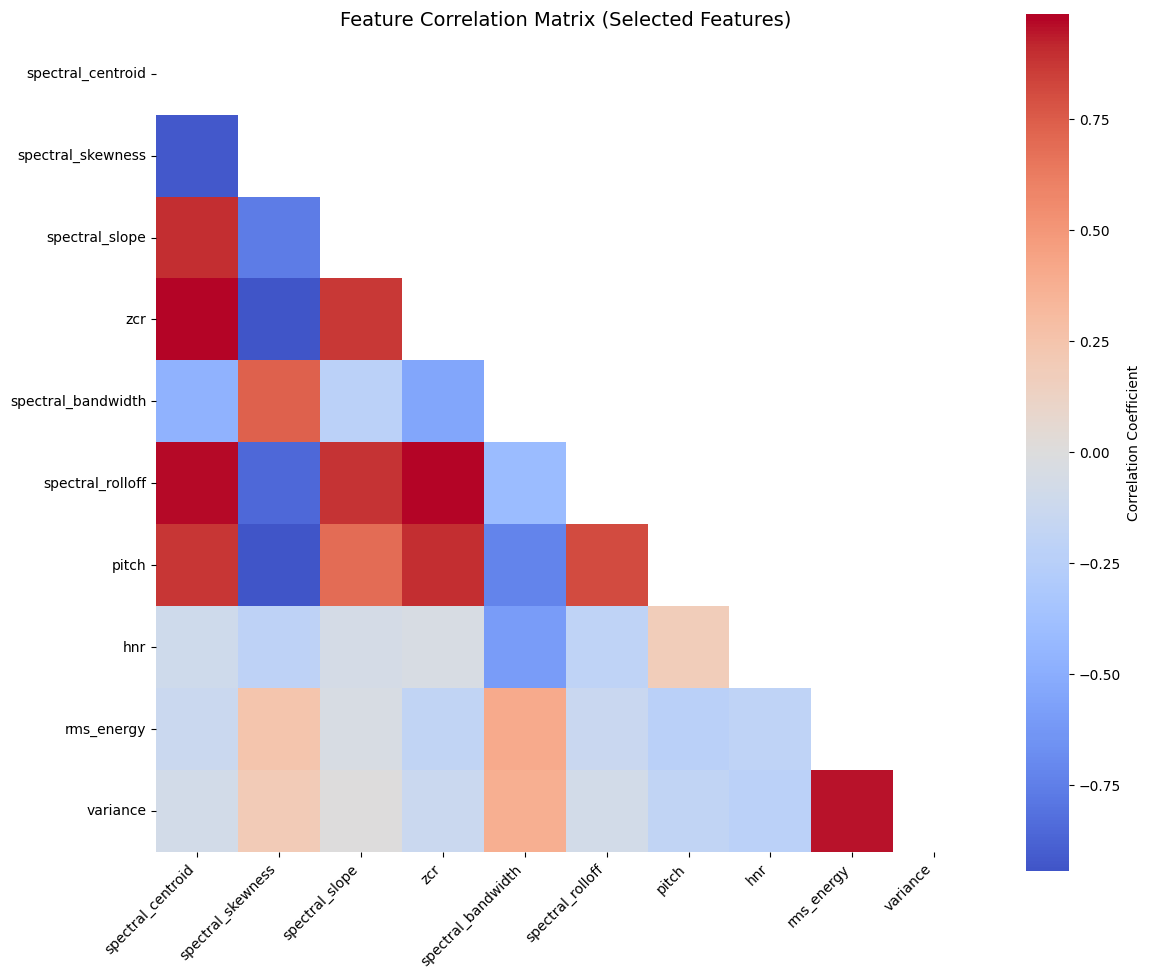

✓ Correlation heatmap created


In [15]:
# Create correlation heatmap
if 'correlation_matrix' in locals() and correlation_matrix.size > 0:
    print("🗺️ Creating correlation heatmap...")
    
    # Create heatmap with subset of features for readability
    max_features_to_plot = 20
    if len(feature_names_for_corr) > max_features_to_plot:
        # Select most discriminative features for the heatmap
        selected_indices = []
        for feat_name in most_discriminative[:max_features_to_plot//2]:
            # Find matching indices
            for i, name in enumerate(feature_names_for_corr):
                if name.startswith(feat_name):
                    selected_indices.append(i)
                    if len(selected_indices) >= max_features_to_plot:
                        break
            if len(selected_indices) >= max_features_to_plot:
                break
        
        # Ensure we have at least some features
        if len(selected_indices) < 10:
            selected_indices = list(range(min(max_features_to_plot, len(feature_names_for_corr))))
        
        plot_corr_matrix = correlation_matrix[np.ix_(selected_indices, selected_indices)]
        plot_feature_names = [feature_names_for_corr[i] for i in selected_indices]
    else:
        plot_corr_matrix = correlation_matrix
        plot_feature_names = feature_names_for_corr
    
    # Create the heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(plot_corr_matrix, dtype=bool))
    sns.heatmap(plot_corr_matrix, 
                mask=mask,
                annot=False, 
                cmap='coolwarm', 
                center=0,
                square=True,
                xticklabels=plot_feature_names,
                yticklabels=plot_feature_names,
                cbar_kws={'label': 'Correlation Coefficient'})
    
    plt.title('Feature Correlation Matrix (Selected Features)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("✓ Correlation heatmap created")

## Principal Component Analysis

In [16]:
# Apply PCA to different aggregation methods and compare
print("🔍 PCA Analysis for Different Aggregation Methods")

pca_results = {}
n_components = 10

for method_name, aggregated_data in aggregated_datasets.items():
    if not aggregated_data:
        continue
        
    print(f"\n📊 Applying PCA to '{method_name}' aggregation...")
    
    try:
        if method_name == 'stack':
            # Stack method produces numpy arrays
            feature_matrix = np.array(aggregated_data)
            if feature_matrix.ndim > 2:
                feature_matrix = feature_matrix.reshape(feature_matrix.shape[0], -1)
        else:
            # Dictionary-based methods - convert to matrix
            feature_vectors = []
            for sample_features in aggregated_data:
                # Flatten all features for this sample
                flat_features = []
                for feat_values in sample_features.values():
                    flat_features.extend(feat_values.flatten())
                feature_vectors.append(flat_features)
            feature_matrix = np.array(feature_vectors)
        
        print(f"  Feature matrix shape: {feature_matrix.shape}")
        
        # Check for valid data
        if feature_matrix.shape[0] < 2 or feature_matrix.shape[1] < 2:
            print(f"  ⚠️ Insufficient data for PCA: {feature_matrix.shape}")
            continue
            
        # Standardize features
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        # Apply PCA
        n_components_actual = min(n_components, feature_matrix_scaled.shape[0]-1, feature_matrix_scaled.shape[1])
        pca = PCA(n_components=n_components_actual)
        pca_transformed = pca.fit_transform(feature_matrix_scaled)
        
        pca_results[method_name] = {
            'pca_model': pca,
            'transformed_data': pca_transformed,
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
            'original_shape': feature_matrix.shape,
            'n_components': n_components_actual
        }
        
        print(f"  ✓ PCA completed: {feature_matrix.shape} -> {pca_transformed.shape}")
        print(f"  ✓ Explained variance (first 5 components): {pca.explained_variance_ratio_[:5]}")
        print(f"  ✓ Cumulative variance (first 5): {np.cumsum(pca.explained_variance_ratio_)[:5]}")
        
    except Exception as e:
        print(f"  ❌ PCA failed for {method_name}: {e}")
        continue

print(f"\n✅ PCA analysis completed for {len(pca_results)} aggregation methods")

🔍 PCA Analysis for Different Aggregation Methods

📊 Applying PCA to 'mean' aggregation...
  Feature matrix shape: (50, 190)
  ✓ PCA completed: (50, 190) -> (50, 10)
  ✓ Explained variance (first 5 components): [0.43119571 0.12440079 0.06281314 0.05681495 0.04695594]
  ✓ Cumulative variance (first 5): [0.43119571 0.5555965  0.61840964 0.67522459 0.72218053]

📊 Applying PCA to 'std' aggregation...
  Feature matrix shape: (50, 190)
  ✓ PCA completed: (50, 190) -> (50, 10)
  ✓ Explained variance (first 5 components): [0.36120475 0.15621412 0.09884185 0.06612797 0.04864527]
  ✓ Cumulative variance (first 5): [0.36120475 0.51741886 0.61626071 0.68238868 0.73103394]

📊 Applying PCA to 'summary' aggregation...
  Feature matrix shape: (50, 380)
  ✓ PCA completed: (50, 380) -> (50, 10)
  ✓ Explained variance (first 5 components): [0.3755085  0.12583809 0.08087404 0.05577765 0.04907562]
  ✓ Cumulative variance (first 5): [0.3755085  0.50134658 0.58222062 0.63799827 0.68707388]

📊 Applying PCA to 

📈 Creating PCA visualizations...


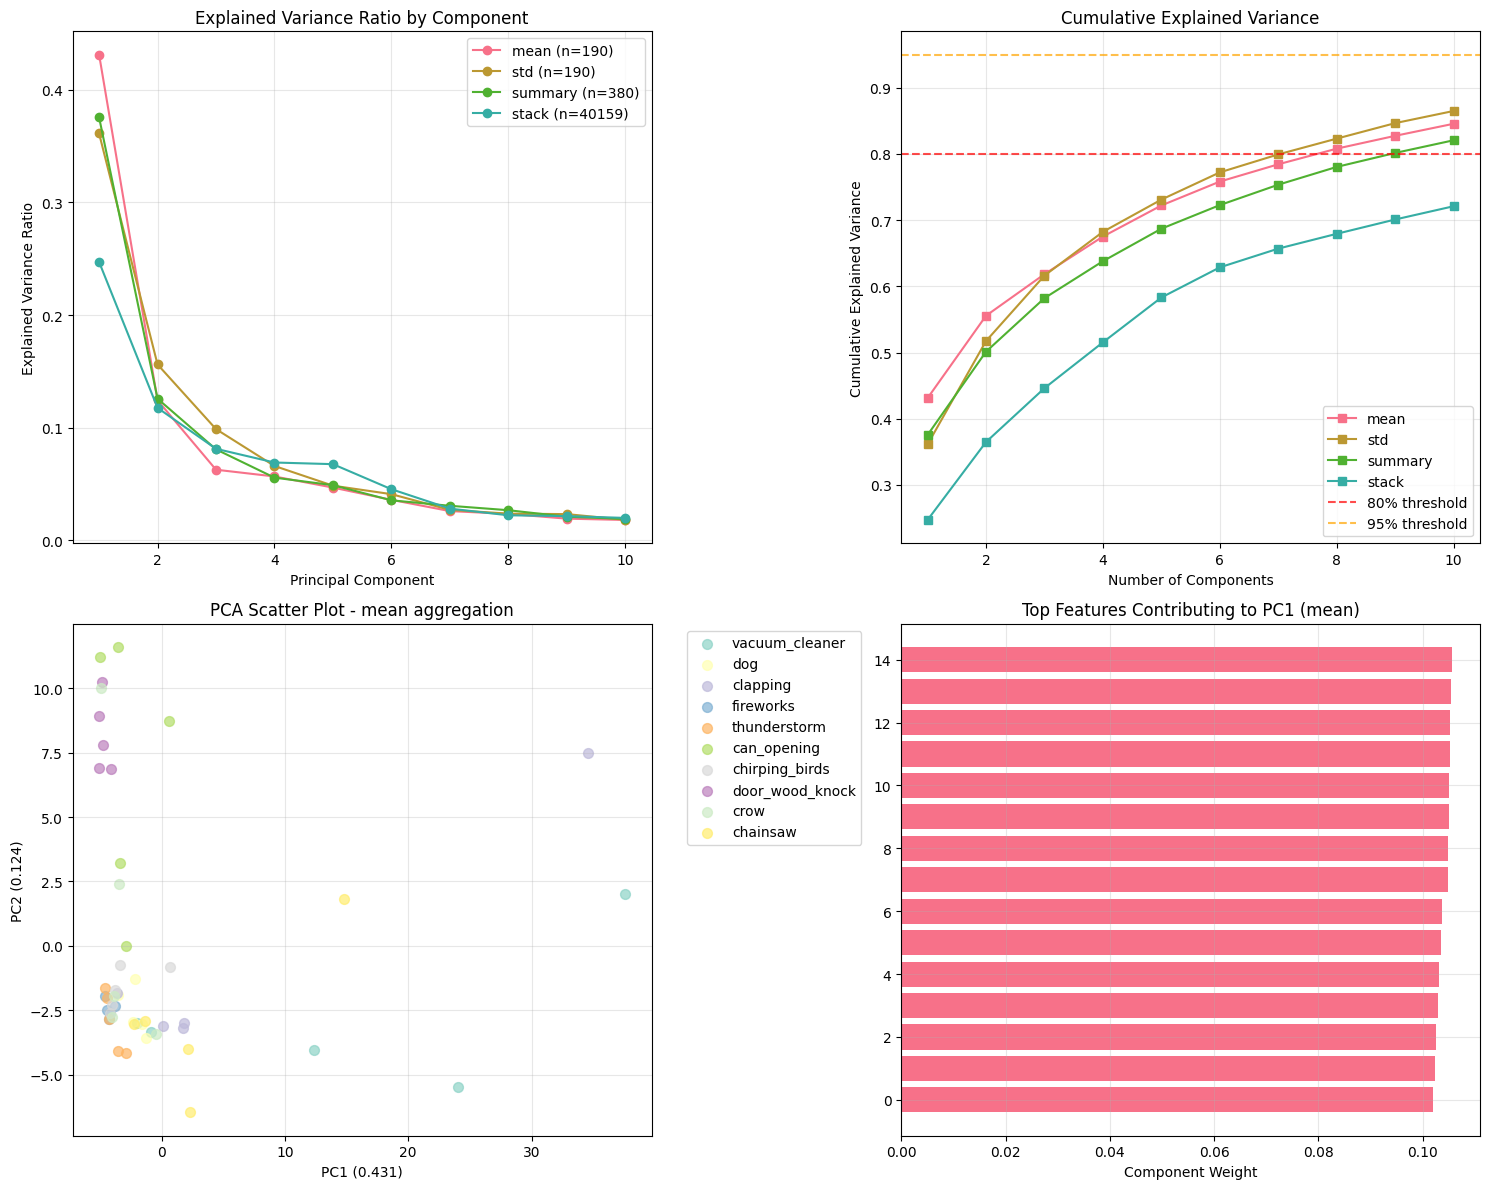

✓ PCA visualization completed

📋 PCA Summary:
  mean      : 80% variance in 8 components, 95% variance in N/A components
  std       : 80% variance in 8 components, 95% variance in N/A components
  summary   : 80% variance in 9 components, 95% variance in N/A components
  stack     : 80% variance in N/A components, 95% variance in N/A components


In [17]:
# Visualize PCA results
if pca_results:
    print("📈 Creating PCA visualizations...")
    
    # 1. Explained variance comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Explained variance ratio
    ax1 = axes[0, 0]
    for method_name, results in pca_results.items():
        n_comp = len(results['explained_variance_ratio'])
        ax1.plot(range(1, n_comp + 1), results['explained_variance_ratio'], 
                marker='o', label=f'{method_name} (n={results["original_shape"][1]})')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Explained Variance Ratio by Component')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Cumulative explained variance
    ax2 = axes[0, 1]
    for method_name, results in pca_results.items():
        n_comp = len(results['cumulative_variance'])
        ax2.plot(range(1, n_comp + 1), results['cumulative_variance'], 
                marker='s', label=method_name)
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.set_title('Cumulative Explained Variance')
    ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% threshold')
    ax2.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95% threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # PCA scatter plots (first 2 components) - choose best method
    best_method = max(pca_results.keys(), 
                     key=lambda x: pca_results[x]['cumulative_variance'][0] if len(pca_results[x]['cumulative_variance']) > 0 else 0)
    
    if best_method and pca_results[best_method]['transformed_data'].shape[1] >= 2:
        ax3 = axes[1, 0]
        pca_data = pca_results[best_method]['transformed_data']
        
        # Color by class
        unique_labels = list(set(labels))
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
        
        for i, label in enumerate(unique_labels):
            mask = np.array(labels) == label
            ax3.scatter(pca_data[mask, 0], pca_data[mask, 1], 
                       c=[colors[i]], label=label, alpha=0.7, s=50)
        
        ax3.set_xlabel(f'PC1 ({pca_results[best_method]["explained_variance_ratio"][0]:.3f})')
        ax3.set_ylabel(f'PC2 ({pca_results[best_method]["explained_variance_ratio"][1]:.3f})')
        ax3.set_title(f'PCA Scatter Plot - {best_method} aggregation')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True, alpha=0.3)
    
    # Feature contribution to first PC
    ax4 = axes[1, 1]
    if best_method in pca_results:
        pc1_components = pca_results[best_method]['pca_model'].components_[0]
        # Show top contributing features
        top_features_idx = np.argsort(np.abs(pc1_components))[-15:]
        ax4.barh(range(len(top_features_idx)), pc1_components[top_features_idx])
        ax4.set_xlabel('Component Weight')
        ax4.set_title(f'Top Features Contributing to PC1 ({best_method})')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ PCA visualization completed")
    
    # Print summary statistics
    print(f"\n📋 PCA Summary:")
    for method_name, results in pca_results.items():
        var_80 = np.where(results['cumulative_variance'] >= 0.8)[0]
        var_95 = np.where(results['cumulative_variance'] >= 0.95)[0]
        
        print(f"  {method_name:10s}: "
              f"80% variance in {var_80[0]+1 if len(var_80) > 0 else 'N/A'} components, "
              f"95% variance in {var_95[0]+1 if len(var_95) > 0 else 'N/A'} components")

## Summary and Insights

In [18]:
# Generate comprehensive summary and insights
print("📋 ANALYSIS SUMMARY")
print("=" * 50)

# Dataset summary
print(f"\n📊 Dataset Analysis:")
print(f"  • Analyzed {len(extracted_features)} audio samples")
print(f"  • {len(set(labels))} different classes: {set(labels)}")
print(f"  • Audio duration range: {min([info['duration'] for info in file_info]):.2f}s - {max([info['duration'] for info in file_info]):.2f}s")

# Feature extraction summary
if extracted_features:
    print(f"\n🔍 Feature Extraction:")
    feature_types = list(extracted_features[0].keys())
    print(f"  • Extracted {len(feature_types)} feature types: {feature_types}")
    
    total_raw_dims = sum(np.prod(feat.shape) for feat in extracted_features[0].values())
    print(f"  • Total raw feature dimensions: {total_raw_dims}")

# Aggregation method comparison
if aggregated_datasets:
    print(f"\n⚖️ Aggregation Method Comparison:")
    for method, data in aggregated_datasets.items():
        if not data:
            continue
        if method == 'stack':
            dims = data[0].shape[0] if data else 0
        else:
            dims = sum(np.prod(v.shape) for v in data[0].values()) if data else 0
        print(f"  • {method:8s}: {dims:5d} dimensions per sample")

# Most discriminative features
if 'most_discriminative' in locals():
    print(f"\n🏆 Most Discriminative Features (Top 10):")
    for i, feat_name in enumerate(most_discriminative[:10]):
        score = discriminative_scores.get(feat_name, 0)
        print(f"  {i+1:2d}. {feat_name:25s} (score: {score:.4f})")

# Feature category analysis
if 'category_stats' in locals():
    print(f"\n🏷️ Feature Category Ranking:")
    sorted_cats = sorted(category_stats.items(), key=lambda x: x[1]['mean_discriminative_score'], reverse=True)
    for i, (category, stats) in enumerate(sorted_cats):
        print(f"  {i+1}. {category:12s}: avg_score={stats['mean_discriminative_score']:.4f} ({stats['num_features']} features)")

# High correlations
if 'high_correlations' in locals():
    print(f"\n🔗 Feature Redundancy:")
    if high_correlations:
        print(f"  • Found {len(high_correlations)} highly correlated feature pairs (|r| > 0.8)")
        print(f"  • Strongest correlations:")
        for feat1, feat2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True)[:5]:
            print(f"    - {feat1} <-> {feat2}: r = {corr:.3f}")
    else:
        print(f"  • No highly correlated features found (good feature diversity)")

# PCA insights
if pca_results:
    print(f"\n📈 Dimensionality Reduction Insights:")
    best_method = max(pca_results.keys(), 
                     key=lambda x: pca_results[x]['cumulative_variance'][0] if len(pca_results[x]['cumulative_variance']) > 0 else 0)
    
    print(f"  • Best aggregation method for PCA: {best_method}")
    
    for method_name, results in pca_results.items():
        var_80_idx = np.where(results['cumulative_variance'] >= 0.8)[0]
        var_95_idx = np.where(results['cumulative_variance'] >= 0.95)[0]
        
        comp_80 = var_80_idx[0] + 1 if len(var_80_idx) > 0 else "N/A"
        comp_95 = var_95_idx[0] + 1 if len(var_95_idx) > 0 else "N/A"
        reduction_ratio = results['original_shape'][1] / (var_80_idx[0] + 1) if len(var_80_idx) > 0 else 1
        
        print(f"  • {method_name:8s}: {comp_80:>3} components for 80% variance (reduction: {reduction_ratio:.1f}x)")

# Recommendations
print(f"\n💡 RECOMMENDATIONS FOR CNN DESIGN:")
print(f"=" * 50)

if 'sorted_categories' in locals():
    best_category = sorted_categories[0][0] if sorted_categories else "unknown"
    print(f"1. Focus on {best_category} features as they show highest discriminative power")

if 'most_discriminative' in locals():
    print(f"2. Prioritize these top discriminative features: {', '.join(most_discriminative[:5])}")

if pca_results:
    best_agg = max(pca_results.keys(), key=lambda x: len(pca_results[x]['cumulative_variance']))
    print(f"3. Use '{best_agg}' aggregation method for optimal feature representation")

if 'high_correlations' in locals() and high_correlations:
    print(f"4. Consider feature selection to remove {len(high_correlations)} redundant feature pairs")
else:
    print(f"4. Feature set shows good diversity with minimal redundancy")

if pca_results:
    avg_80_components = np.mean([np.where(results['cumulative_variance'] >= 0.8)[0][0] + 1 
                                for results in pca_results.values() 
                                if len(np.where(results['cumulative_variance'] >= 0.8)[0]) > 0])
    print(f"5. Consider dimensionality reduction to ~{int(avg_80_components)} components for 80% variance retention")

📋 ANALYSIS SUMMARY

📊 Dataset Analysis:
  • Analyzed 50 audio samples
  • 10 different classes: {'vacuum_cleaner', 'dog', 'clapping', 'fireworks', 'thunderstorm', 'can_opening', 'chirping_birds', 'door_wood_knock', 'crow', 'chainsaw'}
  • Audio duration range: 5.00s - 5.00s

🔍 Feature Extraction:
  • Extracted 16 feature types: ['zcr', 'variance', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_skewness', 'spectral_slope', 'melspectrogram', 'mfcc', 'mfcc_delta', 'chroma_cqt', 'pitch', 'thd', 'hnr', 'gfcc']
  • Total raw feature dimensions: 40159

⚖️ Aggregation Method Comparison:
  • mean    :   190 dimensions per sample
  • std     :   190 dimensions per sample
  • summary :   380 dimensions per sample
  • stack   : 40159 dimensions per sample

🏆 Most Discriminative Features (Top 10):
   1. spectral_centroid         (score: 2.7794)
   2. spectral_skewness         (score: 2.6438)
   3. spectral_slope            (score: 2.4245)
   4. zcr           